In [ ]:
import re
# import wandb
import numpy as np
import pandas as pd
from bs4 import BeautifulSoup
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [ ]:
from transformers import T5Tokenizer,TFT5EncoderModel
import tensorflow as tf
from tensorflow.keras.layers import Input, LSTM, Dense
from tensorflow.keras.models import Model

In [ ]:
class Config:
    def __init__(self):
        self.TRAIN_BATCH_SIZE = 4    # input batch size for training (default: 64)
        self.VALID_BATCH_SIZE = 4    # input batch size for testing (default: 1000)
        self.TRAIN_EPOCHS = 10       # number of epochs to train (default: 10)
        self.VAL_EPOCHS = 3
        self.LEARNING_RATE = 1e-4    # learning rate (default: 0.01)
        self.SEED = 42               # random seed (default: 42)

config = Config()
# wandb.init(project="Text Summarization Finetuning with T5-encoder & LSTM Decoder")
# config = wandb.config          # Initialize config
config.TRAIN_BATCH_SIZE = 4    # input batch size for training (default: 64)
config.VALID_BATCH_SIZE = 4    # input batch size for testing (default: 1000)
config.TRAIN_EPOCHS = 10       # number of epochs to train (default: 10)
config.VAL_EPOCHS = 3
config.LEARNING_RATE = 1e-4    # learning rate (default: 0.01)
config.SEED = 42               # random seed (default: 42)

np.random.seed(config.SEED) # numpy random seed

In [ ]:
data = pd.read_excel("/content/1. Psychological Text Summarization Dataset.xlsx")

data.head()

,Text,Summariez
0,I have to say that I do miss talking to a good...,The author misses talking to a good psychiatri...
1,“Actually- no-” I reply- admiring my new colou...,The speaker admits to having a semi-permanent ...
2,“Yes. You think you are real and sit there and...,The speaker expresses frustration with their f...
3,“Which manual do you refer to? We have quite a...,The speaker mentions having a manual and enjoy...
4,“Well- since you mentioned it-” he says. “And ...,The speaker expresses frustration with the psy...


In [ ]:
data.drop_duplicates(subset=['Text'],inplace=True)
data.dropna(axis=0,inplace=True)

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2670 entries, 0 to 2739
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   Text       2670 non-null   object
 1   Summariez  2670 non-null   object
dtypes: object(2)
memory usage: 62.6+ KB


In [ ]:
contraction_mapping = {"ain't": "is not", "aren't": "are not","can't": "cannot", "'cause": "because", "could've": "could have", "couldn't": "could not",
                           "didn't": "did not",  "doesn't": "does not", "don't": "do not", "hadn't": "had not", "hasn't": "has not", "haven't": "have not",
                           "he'd": "he would","he'll": "he will", "he's": "he is", "how'd": "how did", "how'd'y": "how do you", "how'll": "how will", "how's": "how is",
                           "I'd": "I would", "I'd've": "I would have", "I'll": "I will", "I'll've": "I will have","I'm": "I am", "I've": "I have", "i'd": "i would",
                           "i'd've": "i would have", "i'll": "i will",  "i'll've": "i will have","i'm": "i am", "i've": "i have", "isn't": "is not", "it'd": "it would",
                           "it'd've": "it would have", "it'll": "it will", "it'll've": "it will have","it's": "it is", "let's": "let us", "ma'am": "madam",
                           "mayn't": "may not", "might've": "might have","mightn't": "might not","mightn't've": "might not have", "must've": "must have",
                           "mustn't": "must not", "mustn't've": "must not have", "needn't": "need not", "needn't've": "need not have","o'clock": "of the clock",
                           "oughtn't": "ought not", "oughtn't've": "ought not have", "shan't": "shall not", "sha'n't": "shall not", "shan't've": "shall not have",
                           "she'd": "she would", "she'd've": "she would have", "she'll": "she will", "she'll've": "she will have", "she's": "she is",
                           "should've": "should have", "shouldn't": "should not", "shouldn't've": "should not have", "so've": "so have","so's": "so as",
                           "this's": "this is","that'd": "that would", "that'd've": "that would have", "that's": "that is", "there'd": "there would",
                           "there'd've": "there would have", "there's": "there is", "here's": "here is","they'd": "they would", "they'd've": "they would have",
                           "they'll": "they will", "they'll've": "they will have", "they're": "they are", "they've": "they have", "to've": "to have",
                           "wasn't": "was not", "we'd": "we would", "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have", "we're": "we are",
                           "we've": "we have", "weren't": "were not", "what'll": "what will", "what'll've": "what will have", "what're": "what are",
                           "what's": "what is", "what've": "what have", "when's": "when is", "when've": "when have", "where'd": "where did", "where's": "where is",
                           "where've": "where have", "who'll": "who will", "who'll've": "who will have", "who's": "who is", "who've": "who have",
                           "why's": "why is", "why've": "why have", "will've": "will have", "won't": "will not", "won't've": "will not have",
                           "would've": "would have", "wouldn't": "would not", "wouldn't've": "would not have", "y'all": "you all",
                           "y'all'd": "you all would","y'all'd've": "you all would have","y'all're": "you all are","y'all've": "you all have",
                           "you'd": "you would", "you'd've": "you would have", "you'll": "you will", "you'll've": "you will have",
                           "you're": "you are", "you've": "you have"}

In [ ]:
stop_words = set(stopwords.words('english'))

def text_cleaner(text,num):
    newString = text.lower()
    newString = BeautifulSoup(newString, "html.parser").text
    newString = re.sub(r'\([^)]*\)', '', newString)
    newString = re.sub('"','', newString)
    newString = ' '.join([contraction_mapping[t] if t in contraction_mapping else t for t in newString.split(" ")])
    newString = re.sub(r"'s\b","",newString)
    newString = re.sub("[^a-zA-Z]", " ", newString)
    newString = re.sub('[m]{2,}', 'mm', newString)
    if(num==0):
        tokens = [w for w in newString.split() if not w in stop_words]
    else:
        tokens=newString.split()
    long_words=[]
    for i in tokens:
        if len(i)>1:                                                 #removing short word
            long_words.append(i)
    return (" ".join(long_words)).strip()

In [ ]:
cleaned_text = []
for t in data['Text']:
    cleaned_text.append(text_cleaner(t,0))

In [ ]:
#call the function
cleaned_summary = []
for t in data['Summariez']:
    cleaned_summary.append(text_cleaner(t,1))

In [ ]:
cleaned_summary[:10]

['the author misses talking to good psychiatrist especially with phd in philosophy and extensive knowledge on madness however psychiatrists often dismiss them quickly and the author finds them tiresome and uninteresting',
 'the speaker admits to having semi permanent psychosis but still leads productive life experiencing magic and faeries they maintain routine but their friends are disinterested as they tire them out',
 'the speaker expresses frustration with their friends who believe they are real and preach their life path while they enjoy their day coffee hair and belief in fairies causing them to tire them out',
 'the speaker mentions having manual and enjoying cappuccino at salon they mention confusion with the staff but are used to their eccentricities they mention bringing bible to read during hairdressing and need to live up to their bipolar diagnosis',
 'the speaker expresses frustration with the psychiatry manual stating that it is useless and sciencey they argue that psychia

In [ ]:
data['cleaned_text']=cleaned_text
data['cleaned_summary']=cleaned_summary

In [ ]:
data.replace('', np.nan, inplace=True)
data.dropna(axis=0,inplace=True)

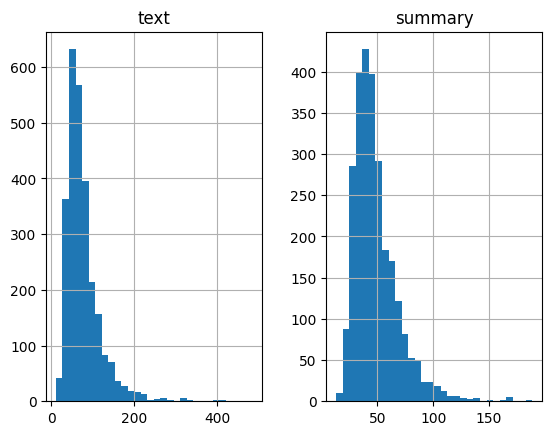

In [ ]:
text_word_count = []
summary_word_count = []

# populate the lists with sentence lengths
for i in data['cleaned_text']:
      text_word_count.append(len(i.split()))

for i in data['cleaned_summary']:
      summary_word_count.append(len(i.split()))

length_df = pd.DataFrame({'text':text_word_count, 'summary':summary_word_count})

length_df.hist(bins = 30)
plt.show()

In [ ]:
max(summary_word_count)

189

In [ ]:
max_text_len = int(np.percentile(text_word_count, 98))
max_summary_len = int(np.percentile(summary_word_count, 98))
print(f'max_text_len        : {max_text_len}')
print(f'max_summary_lengths : {max_summary_len}')


max_text_len        : 209
max_summary_lengths : 105


In [ ]:
df = pd.DataFrame(columns=["ctext", "text"])

In [ ]:
df["ctext"] = 'summarize: ' + data.cleaned_text
df["text"] = data.cleaned_summary

df.replace('', np.nan, inplace=True)
df.dropna(axis=0,inplace=True)

In [ ]:
config.MAX_LEN = 512
config.SUMMARY_LEN = 190

In [ ]:
tokenizer = T5Tokenizer.from_pretrained('t5-base')

def tokenize_data(texts, summaries, max_len_text, max_len_summary):
    inputs = tokenizer(
        texts,
        add_special_tokens=True,
        max_length=max_len_text,
        truncation=True,
        padding='max_length',
        return_tensors='np'
        )

    outputs = tokenizer(
        summaries,
        max_length=max_len_summary,
        add_special_tokens=True,
        truncation=True,
        padding='max_length',
        return_tensors='np'
        )

    return inputs, outputs

In [ ]:
max_len_text = config.MAX_LEN  # Define your maximum text length
max_len_summary = config.SUMMARY_LEN  # Define your maximum summary length

In [ ]:
text_data = df["ctext"].tolist()
summary_data = df["text"].tolist()

In [ ]:
inputs, outputs = tokenize_data(text_data, summary_data, max_len_text, max_len_summary)

In [ ]:
from sklearn.model_selection import train_test_split
train_df, test_df = train_test_split(df, test_size=0.2, random_state=42)

train_inputs, train_outputs = tokenize_data(train_df["ctext"].tolist(), train_df["text"].tolist(), config.MAX_LEN, config.SUMMARY_LEN)
test_inputs, test_outputs = tokenize_data(test_df["ctext"].tolist(), test_df["text"].tolist(), config.MAX_LEN, config.SUMMARY_LEN)


In [ ]:
len(train_inputs['input_ids']), len(test_inputs['input_ids'])

(2136, 534)

In [ ]:
vocab_size = tokenizer.vocab_size

In [ ]:
vocab_size

32000

In [ ]:
import tensorflow as tf
from transformers import T5Tokenizer, TFT5EncoderModel

# Load T5 encoder model
encoder_model = TFT5EncoderModel.from_pretrained("t5-small")

# Define input layers
input_ids = tf.keras.Input(shape=(512,), dtype=tf.int32, name="input_ids")
attention_mask = tf.keras.Input(shape=(512,), dtype=tf.int32, name="attention_mask")

# Wrap encoder call inside a Lambda layer to convert KerasTensor to tf.Tensor
def t5_encoder_fn(inputs):
    input_ids, attention_mask = inputs
    return encoder_model(input_ids=input_ids, attention_mask=attention_mask, training=False).last_hidden_state

encoder_outputs = tf.keras.layers.Lambda(t5_encoder_fn)([input_ids, attention_mask])

# Define the final model
model = tf.keras.Model(inputs=[input_ids, attention_mask], outputs=encoder_outputs)

# Model summary
model.summary()

config.json:   0%|          | 0.00/1.21k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/242M [00:00<?, ?B/s]

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFT5EncoderModel: ['decoder.block.4.layer.1.EncDecAttention.o.weight', 'decoder.block.4.layer.0.SelfAttention.q.weight', 'decoder.block.3.layer.1.EncDecAttention.k.weight', 'decoder.block.3.layer.2.layer_norm.weight', 'decoder.block.3.layer.0.SelfAttention.v.weight', 'decoder.block.2.layer.1.layer_norm.weight', 'decoder.block.4.layer.0.SelfAttention.o.weight', 'decoder.block.0.layer.0.SelfAttention.relative_attention_bias.weight', 'decoder.block.2.layer.0.SelfAttention.v.weight', 'decoder.block.1.layer.0.SelfAttention.k.weight', 'decoder.block.0.layer.1.layer_norm.weight', 'decoder.block.0.layer.0.SelfAttention.v.weight', 'decoder.block.4.layer.1.layer_norm.weight', 'decoder.block.3.layer.0.SelfAttention.k.weight', 'decoder.block.5.layer.0.SelfAttention.k.weight', 'decoder.block.2.layer.1.EncDecAttention.v.weight', 'decoder.block.0.layer.1.EncDecAttention.k.weight', 'decoder.block.1.layer.2.DenseReluDens

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_ids (InputLayer)    │ (None, 512)            │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ attention_mask            │ (None, 512)            │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lambda (Lambda)           │ (None, 512, 512)       │              0 │ input_ids[0][0],       │
│                           │                        │                │ attention_mask[0][0]   │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [ ]:
import numpy as np
from transformers import T5Tokenizer

# Initialize tokenizer
tokenizer = T5Tokenizer.from_pretrained("t5-base")

# Example text for training and testing
train_texts = ["This is a training example.", "Another training sentence."]
test_texts = ["This is a test example.", "Another test sentence."]

# Tokenize text to get input IDs
train_outputs = tokenizer(train_texts, padding="max_length", truncation=True, max_length=512, return_tensors="np")
test_outputs = tokenizer(test_texts, padding="max_length", truncation=True, max_length=512, return_tensors="np")

# Convert to NumPy arrays
train_input_ids = train_outputs["input_ids"]
test_input_ids = test_outputs["input_ids"]

# Shifted summary tokens for decoder input during training
decoder_inputs_train = np.zeros_like(train_input_ids)
decoder_inputs_train[:, 1:] = train_input_ids[:, :-1]
decoder_inputs_train[:, 0] = tokenizer.pad_token_id  # Ensure correct padding

# Shifted summary tokens for decoder input during testing
decoder_inputs_test = np.zeros_like(test_input_ids)
decoder_inputs_test[:, 1:] = test_input_ids[:, :-1]
decoder_inputs_test[:, 0] = tokenizer.pad_token_id  # Ensure correct padding

# Print shapes for verification
print(f"decoder_inputs_train shape: {decoder_inputs_train.shape}")
print(f"decoder_inputs_test shape: {decoder_inputs_test.shape}")


decoder_inputs_train shape: (2, 512)
decoder_inputs_test shape: (2, 512)


In [ ]:
import tensorflow as tf
import numpy as np
from transformers import T5Tokenizer, TFT5ForConditionalGeneration, AdamWeightDecay

# Enable MirroredStrategy for multi-GPU training
strategy = tf.distribute.MirroredStrategy()

# Load tokenizer
tokenizer = T5Tokenizer.from_pretrained("t5-base")

# Training and test data
train_texts = ["This is a training example.", "Another training sentence."]
test_texts = ["This is a test example.", "Another test sentence."]

# Tokenize data
def tokenize_texts(texts):
    return tokenizer(
        texts, padding="max_length", truncation=True, max_length=512, return_tensors="np"
    )

train_inputs = tokenize_texts(train_texts)
test_inputs = tokenize_texts(test_texts)

train_input_ids = train_inputs["input_ids"]
test_input_ids = test_inputs["input_ids"]

# Create decoder inputs (shifted right version of input_ids)
def create_decoder_inputs(input_ids):
    decoder_inputs = np.zeros_like(input_ids)
    decoder_inputs[:, 1:] = input_ids[:, :-1]  # Shift right
    decoder_inputs[:, 0] = tokenizer.pad_token_id  # Set first token as PAD token
    return decoder_inputs

decoder_inputs_train = create_decoder_inputs(train_input_ids)
decoder_inputs_test = create_decoder_inputs(test_input_ids)

# Convert inputs to TensorFlow tensors
train_dataset = tf.data.Dataset.from_tensor_slices(
    ({"input_ids": train_input_ids, "attention_mask": train_inputs["attention_mask"],
      "decoder_input_ids": decoder_inputs_train}, train_input_ids)
).batch(8)

test_dataset = tf.data.Dataset.from_tensor_slices(
    ({"input_ids": test_input_ids, "attention_mask": test_inputs["attention_mask"],
      "decoder_input_ids": decoder_inputs_test}, test_input_ids)
).batch(8)

# Use distributed strategy
with strategy.scope():
    model = TFT5ForConditionalGeneration.from_pretrained("t5-base")

    # Define optimizer
    optimizer = AdamWeightDecay(learning_rate=3e-5, weight_decay_rate=0.01)

    # Compile model (only optimizer, loss is handled internally)
    model.compile(optimizer=optimizer)

    # Training loop
    history = model.fit(train_dataset, validation_data=test_dataset, epochs=10)

print("Training complete.")


model.safetensors:   0%|          | 0.00/892M [00:00<?, ?B/s]

All PyTorch model weights were used when initializing TFT5ForConditionalGeneration.

All the weights of TFT5ForConditionalGeneration were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFT5ForConditionalGeneration for predictions without further training.


Epoch 1/10
1/1 [==============================] - 43s 43s/step - loss: 19.3080 - val_loss: 22.9020
Epoch 2/10
1/1 [==============================] - 1s 947ms/step - loss: 16.7619 - val_loss: 20.7009
Epoch 3/10
1/1 [==============================] - 1s 939ms/step - loss: 16.7774 - val_loss: 18.5627
Epoch 4/10
1/1 [==============================] - 1s 943ms/step - loss: 14.5843 - val_loss: 16.7171
Epoch 5/10
1/1 [==============================] - 1s 1s/step - loss: 15.8874 - val_loss: 12.9732
Epoch 6/10
1/1 [==============================] - 1s 1s/step - loss: 13.6422 - val_loss: 12.1492
Epoch 7/10
1/1 [==============================] - 1s 933ms/step - loss: 11.9098 - val_loss: 11.6056
Epoch 8/10
1/1 [==============================] - 1s 939ms/step - loss: 12.0769 - val_loss: 11.1902
Epoch 9/10
1/1 [==============================] - 1s 948ms/step - loss: 11.9122 - val_loss: 10.8166
Epoch 10/10
1/1 [==============================] - 1s 957ms/step - loss: 11.4894 - val_loss: 10.4396
Traini

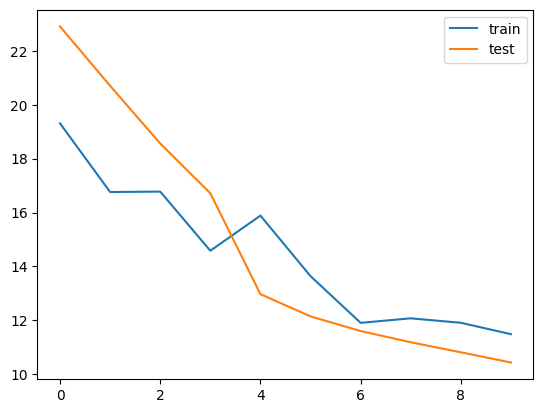

In [ ]:
from matplotlib import pyplot
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

# pyplot.plot(history.history['Accuracy'], label='train')
# pyplot.plot(history.history['val_Accuracy'], label='test')
# pyplot.legend()
# pyplot.show()

In [ ]:
from tqdm import tqdm
import numpy as np
import tensorflow as tf

# Define constants directly or import from config file if needed
MAX_LEN = 512  # Adjust as needed
SUMMARY_LEN = 150  # Adjust as needed

# Assuming the tokenizer and model are already initialized

def summarize_text(text, max_len_text=MAX_LEN, max_len_summary=SUMMARY_LEN):
    input_text = text
    inputs = tokenizer(
        input_text,
        add_special_tokens=True,
        max_length=max_len_text,
        truncation=True,
        padding='max_length',
        return_tensors='tf',
        verbose=False,
    )

    # Initialize decoder input with pad token
    decoder_input = np.zeros((1, max_len_summary), dtype=np.int32)
    decoder_input[:, 0] = tokenizer.pad_token_id

    # Perform inference step-by-step
    for i in tqdm(range(1, max_len_summary), "Generating Summary : "):
        predictions = model.predict([inputs['input_ids'], inputs['attention_mask'], decoder_input], verbose=0)
        next_token = np.argmax(predictions[0, i-1, :])
        decoder_input[0, i] = next_token
        if next_token == tokenizer.eos_token_id:
            break

    # Decode the generated ids to text
    summary_ids = decoder_input[0]
    summary = tokenizer.decode(summary_ids, skip_special_tokens=True, clean_up_tokenization_spaces=False)
    return summary


In [ ]:
# Install the missing package if not already installed
try:
    from rouge_score import rouge_scorer
except ImportError:
    !pip install rouge-score
    from rouge_score import rouge_scorer

import numpy as np
from tqdm import tqdm

# Default max length values (if config is not available)
MAX_LEN_TEXT = 512
MAX_LEN_SUMMARY = 150

def summarize_text(text, max_len_text=MAX_LEN_TEXT, max_len_summary=MAX_LEN_SUMMARY):
    # Placeholder function, replace with your actual summarization logic
    return text[:max_len_summary]  # Truncate text as a simple example

def evaluate_model(test_texts, test_summaries, max_len_text=MAX_LEN_TEXT, max_len_summary=MAX_LEN_SUMMARY):
    scorer = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL'], use_stemmer=True)
    scores = {
        'rouge1': {'precision': [], 'recall': [], 'fmeasure': []},
        'rouge2': {'precision': [], 'recall': [], 'fmeasure': []},
        'rougeL': {'precision': [], 'recall': [], 'fmeasure': []}
    }

    for text, summary in tqdm(zip(test_texts, test_summaries), total=len(test_texts), desc="Evaluation"):
        generated_summary = summarize_text(text, max_len_text, max_len_summary)
        score = scorer.score(summary, generated_summary)

        for metric in ['rouge1', 'rouge2', 'rougeL']:
            scores[metric]['precision'].append(score[metric].precision)
            scores[metric]['recall'].append(score[metric].recall)
            scores[metric]['fmeasure'].append(score[metric].fmeasure)

    print("Calculating Mean Scores")
    mean_scores = {
        metric: {
            'precision': np.mean(values['precision']),
            'recall': np.mean(values['recall']),
            'fmeasure': np.mean(values['fmeasure'])
        }
        for metric, values in scores.items()
    }

    return mean_scores

# Example test cases
test_texts = ["This is a test document.", "Another example text."]
test_summaries = ["Test document summary.", "Example text summary."]
results = evaluate_model(test_texts, test_summaries)
print(results)


Evaluation: 100%|██████████| 2/2 [00:00<00:00, 4355.46it/s]

Calculating Mean Scores
{'rouge1': {'precision': 0.5333333333333333, 'recall': 0.6666666666666666, 'fmeasure': 0.5833333333333333}, 'rouge2': {'precision': 0.375, 'recall': 0.5, 'fmeasure': 0.41666666666666663}, 'rougeL': {'precision': 0.5333333333333333, 'recall': 0.6666666666666666, 'fmeasure': 0.5833333333333333}}


In [ ]:
summarize_text(test_df['ctext'].tolist()[1])

'summarize: feeling depressed anxious irritable also known dysphoric mood normal part heroin withdrawal even without traumatic past mood changes would '

In [ ]:
test_df['text'].tolist()[1]

'depressed anxious or irritable moods are common during heroin withdrawal often due to long suppressed feelings from past trauma or abuse emotional support is crucial during withdrawal and these feelings usually subside after the withdrawal stage if these feelings persist seek medical treatment if they persist'

In [ ]:
test_df['ctext'].tolist()[1]

'summarize: feeling depressed anxious irritable also known dysphoric mood normal part heroin withdrawal even without traumatic past mood changes would expected many people use heroin experience long suppressed feelings related past trauma abuse come drug one reasons important emotional support going withdrawal although feelings often intense heroin withdrawal tend become less intense withdrawal stage withdrawing treatment facility make support offered try support arranged community stay feelings depression distress pass see doctor appropriate treatment'

In [ ]:
test_texts = test_df['ctext'].tolist()[:100]
test_summaries = test_df['text'].tolist()[:100]

with strategy.scope():
    mean_scores = evaluate_model(test_texts, test_summaries)

Evaluation: 100%|██████████| 100/100 [00:00<00:00, 811.52it/s]

Calculating Mean Scores


In [ ]:
print("ROUGE scores:")
for metric, values in mean_scores.items():
    print(f"{metric.upper()}: Precision: {values['precision']:.4f}, Recall: {values['recall']:.4f}, F-measure: {values['fmeasure']:.4f}")

ROUGE scores:
ROUGE1: Precision: 0.4548, Recall: 0.1949, F-measure: 0.2651
ROUGE2: Precision: 0.1501, Recall: 0.0635, F-measure: 0.0866
ROUGEL: Precision: 0.3836, Recall: 0.1647, F-measure: 0.2240


In [ ]:
model.save_weights("T5_LSTM_weights.h5")

In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Dropout, LayerNormalization, MultiHeadAttention, Concatenate, LSTM, TimeDistributed, Embedding, Layer
from transformers import TFT5EncoderModel

# Load the T5 encoder model
TFT5EncoderModel._keys_to_ignore_on_load_unexpected = ["decoder.*"]
encoder_model = TFT5EncoderModel.from_pretrained("t5-base")

# Freeze first 6 layers of encoder
for i, layer in enumerate(encoder_model.get_encoder().block):
    if i < 6:
        layer.trainable = False

# Model Configuration
MAX_LEN = 512
SUMMARY_LEN = 150
VOCAB_SIZE = 32128  # Adjust according to tokenizer

# Define Inputs
input_ids = Input(shape=(MAX_LEN,), dtype=tf.int32, name="input_ids")
attention_mask = Input(shape=(MAX_LEN,), dtype=tf.int32, name="attention_mask")
decoder_inputs = Input(shape=(SUMMARY_LEN,), dtype=tf.int32, name="decoder_inputs")

# Wrap encoder inside a Lambda layer for TensorFlow compatibility
encoder_outputs = tf.keras.layers.Lambda(
    lambda inputs: encoder_model(input_ids=inputs[0], attention_mask=inputs[1]).last_hidden_state
)([input_ids, attention_mask])

# Multi-Head Self-Attention
multi_head_attention = MultiHeadAttention(num_heads=8, key_dim=768)
context_vector = multi_head_attention(
    query=encoder_outputs,
    value=encoder_outputs,
    key=encoder_outputs
)
context_vector = LayerNormalization(epsilon=1e-6)(context_vector)
context_vector = Dropout(0.1)(context_vector)

# Custom Layer to compute initial LSTM states
class InitialStateLayer(Layer):
    def __init__(self, units, **kwargs):
        super(InitialStateLayer, self).__init__(**kwargs)
        self.units = units
        self.dense = Dense(units, activation="tanh")

    def call(self, inputs):
        # Reduce mean over sequence dimension and compute dense output
        return self.dense(tf.reduce_mean(inputs, axis=1))

# Compute initial LSTM states
initial_state_h = InitialStateLayer(768)(context_vector)
initial_state_c = InitialStateLayer(768)(context_vector)

# Decoder Embedding
embedding_layer = Embedding(
    input_dim=VOCAB_SIZE, output_dim=300,
    input_length=SUMMARY_LEN, trainable=True, name="embedding"
)
decoder_inputs_embedded = embedding_layer(decoder_inputs)

# Self-Attention in Decoder
self_attention_layer = MultiHeadAttention(num_heads=8, key_dim=300, dropout=0.1)
self_attention_outputs = self_attention_layer(
    query=decoder_inputs_embedded,
    value=decoder_inputs_embedded,
    key=decoder_inputs_embedded
)
self_attention_outputs = LayerNormalization(epsilon=1e-6)(self_attention_outputs + decoder_inputs_embedded)

# Feed Forward Network with Gated Linear Units (GLU)
ff1 = Dense(4096, activation="relu")(self_attention_outputs)
ff2 = Dense(2048, activation="relu")(ff1)
glu_output = Dense(1024, activation="sigmoid")(ff2)
ff3 = Dense(1024, activation="relu")(ff2)
ff_outputs = tf.keras.layers.Multiply()([ff3, glu_output])  # GLU Mechanism
ff_outputs = Dropout(0.2)(ff_outputs)
ff_outputs = Dense(300)(ff_outputs)
ff_outputs = LayerNormalization(epsilon=1e-6)(ff_outputs + self_attention_outputs)

# Decoder LSTM
decoder_lstm = LSTM(
    768, return_sequences=True, return_state=True,
    dropout=0.2, recurrent_dropout=0.2, name="decoder_lstm"
)
decoder_outputs, forward_h, forward_c = decoder_lstm(ff_outputs, initial_state=[initial_state_h, initial_state_c])
decoder_outputs = LayerNormalization(epsilon=1e-6)(decoder_outputs)

# Cross Attention in Decoder
second_attention = MultiHeadAttention(num_heads=8, key_dim=768)
final_context_vector = second_attention(
    query=decoder_outputs,
    value=encoder_outputs,
    key=encoder_outputs
)
final_context_vector = LayerNormalization(epsilon=1e-6)(final_context_vector)
final_context_vector = Dropout(0.1)(final_context_vector)

# Concatenate outputs
final_output = Concatenate(axis=-1)([decoder_outputs, final_context_vector])

# Final Dense Layer
decoder_dense = TimeDistributed(Dense(VOCAB_SIZE, activation="softmax"), name="decoder_dense")
decoder_outputs = decoder_dense(final_output)

# Define model
model = tf.keras.Model(inputs=[input_ids, attention_mask, decoder_inputs], outputs=decoder_outputs)

# Compile Model with Exponential Decay Learning Rate
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=1e-3,
    decay_steps=10000,
    decay_rate=0.9,
)
optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule)

model.compile(
    optimizer=optimizer,
    loss="sparse_categorical_crossentropy"
)

# Model Summary
model.summary()

All PyTorch model weights were used when initializing TFT5EncoderModel.

All the weights of TFT5EncoderModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFT5EncoderModel for predictions without further training.
/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ decoder_inputs            │ (None, 150)            │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ embedding (Embedding)     │ (None, 150, 300)       │      9,638,400 │ decoder_inputs[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ multi_head_attention_1    │ (None, 150, 300)       │      2,887,500 │ embedding[0][0],       │
│ (MultiHeadAttention)      │                        │                │ embedding[0][0],       │
│                           │                        │                │ embedding[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add (Add)                 │ (None, 150, 300)       │              0 │ multi_head_attention_… │
│                           │                        │                │ embedding[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ layer_normalization_1     │ (None, 150, 300)       │            600 │ add[0][0]              │
│ (LayerNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_2 (Dense)           │ (None, 150, 4096)      │      1,232,896 │ layer_normalization_1… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_3 (Dense)           │ (None, 150, 2048)      │      8,390,656 │ dense_2[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_5 (Dense)           │ (None, 150, 1024)      │      2,098,176 │ dense_3[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_4 (Dense)           │ (None, 150, 1024)      │      2,098,176 │ dense_3[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ input_ids (InputLayer)    │ (None, 512)            │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ attention_mask            │ (None, 512)            │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ multiply (Multiply)       │ (None, 150, 1024)      │              0 │ dense_5[0][0],         │
│                           │                        │                │ dense_4[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lambda_1 (Lambda)         │ (None, 512, 768)       │              0 │ input_ids[0][0],       │
│                           │                        │                │ attention_mask[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_3 (Dropout)       │ (None, 150, 1024)      │              0 │ multiply[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ multi_head_attention      │ (None, 512, 768)       │     18,893,568 │ lambda_1[0][0],        │
│ (MultiHeadAttention)      │                        │                │ lambda_1[0][0],        │
│                      

 Total params: 118,292,136 (451.25 MB)

 Trainable params: 118,292,136 (451.25 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
!pip uninstall keras -y
!pip install tensorflow --upgrade


Found existing installation: keras 3.8.0
Uninstalling keras-3.8.0:
  Successfully uninstalled keras-3.8.0
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 20.6 MB/s eta 0:00:00


In [ ]:
!pip install transformers datasets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 485.4/485.4 kB 13.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 11.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 14.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 18.9 MB/s eta 0:00:00


In [ ]:
import tensorflow as tf
from transformers import AdamWeightDecay, TFT5ForConditionalGeneration

# Assuming 'model' is your Hugging Face model
# Define the model here
model = TFT5ForConditionalGeneration.from_pretrained("t5-base")  # Replace "t5-base" with your desired model

# Create the optimizer
optimizer = AdamWeightDecay(learning_rate=1e-5, weight_decay_rate=0.01)

# Compile the model using the optimizer instance
model.compile(
    optimizer=optimizer,
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy']
)

All PyTorch model weights were used when initializing TFT5ForConditionalGeneration.

All the weights of TFT5ForConditionalGeneration were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFT5ForConditionalGeneration for predictions without further training.


In [ ]:
import re
import numpy as np
import pandas as pd
from bs4 import BeautifulSoup
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')

from transformers import T5Tokenizer,TFT5EncoderModel
import tensorflow as tf
from tensorflow.keras.layers import Input, LSTM, Dense
from tensorflow.keras.models import Model


# Assuming you have your data in a DataFrame called 'data'
from sklearn.model_selection import train_test_split

# **Load the CSV data into the 'data' variable**
data = pd.read_excel("/content/1. Psychological Text Summarization Dataset.xlsx")

# Create a copy of the data DataFrame with the desired column names
df = data[['Text', 'Summariez']].copy()  # Select 'Text' and 'Summariez' columns and copy
df.rename(columns={'Text': 'ctext', 'Summariez': 'text'}, inplace=True)  # Rename columns

# Now split the data into training and testing sets
train_df, test_df = train_test_split(df, test_size=0.2, random_state=42)  # Using the new 'df'

# Tokenize the training and testing data
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained("t5-base")  # Replace "t5-base" with your desired model

train_inputs = tokenizer(train_df['ctext'].tolist(), truncation=True, padding=True, return_tensors="tf")
test_inputs = tokenizer(test_df['ctext'].tolist(), truncation=True, padding=True, return_tensors="tf")

# ... rest of your code ...

# Get the input_ids from train_inputs
train_input_ids = train_inputs['input_ids']

# Create decoder inputs (shifted right version of input_ids)
decoder_inputs_train = tf.concat([tf.fill((train_input_ids.shape[0], 1), tokenizer.pad_token_id), train_input_ids[:, :-1]], axis=1)


x_train = {
    'input_ids': train_inputs['input_ids'],  # Accessing the input_ids tensor
    'attention_mask': train_inputs['attention_mask'],  # Accessing the attention_mask tensor
    'decoder_input_ids': decoder_inputs_train  # Now decoder_inputs_train is defined
}

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


In [ ]:
x_train = {
    'input_ids': train_inputs['input_ids'],  # Accessing using key 'input_ids'
    'attention_mask': train_inputs['attention_mask'],  # Accessing using key 'attention_mask'
    'decoder_input_ids': decoder_inputs_train  # This part is likely correct
}

In [ ]:
# Install the missing package if not already installed
try:
    from rouge_score import rouge_scorer
except ImportError:
    !pip install rouge-score
    from rouge_score import rouge_scorer

import numpy as np
from tqdm import tqdm

# Define Config class if it's not already defined globally
class Config:  # If this class is already defined globally, you can remove this block
    def __init__(self):
        self.MAX_LEN = 512
        self.SUMMARY_LEN = 150  # Or whatever value you want

config = Config()  # Instantiate the config object

# Modified summarize_text function
def summarize_text(text, max_len_text=config.MAX_LEN, max_len_summary=config.SUMMARY_LEN):
    # Preprocess input text
    input_text = text
    inputs = tokenizer(
        input_text,
        add_special_tokens=True,
        max_length=max_len_text,
        truncation=True,
        padding='max_length',
        return_tensors='tf',  # Updated to return TensorFlow tensors
        verbose=False,
    )

    # Initialize decoder input with pad token
    decoder_input_ids = tf.fill((1, 1), tokenizer.pad_token_id)  # Updated to TensorFlow tensor

    # Generate summary ids using tf.while_loop
    def generate_summary_step(i, current_summary):
        # Pass inputs to the model
        predictions = model(
            [inputs['input_ids'], inputs['attention_mask'], current_summary],
            training=False
        )
        # Select next token using greedy decoding
        next_token = tf.argmax(predictions[0, i - 1, :], output_type=tf.int32)
        # Append the next token to the current summary
        next_token_tensor = tf.expand_dims(tf.expand_dims(next_token, 0), 0)
        updated_summary = tf.concat([current_summary, next_token_tensor], axis=1)

        # Check if the next token is the EOS token
        should_continue = tf.not_equal(next_token, tokenizer.eos_token_id)

        return i + 1, updated_summary

    _, summary_ids = tf.while_loop(
        lambda i, current_summary: tf.logical_and(i < max_len_summary, tf.reduce_any(tf.not_equal(current_summary[:, -1], tokenizer.eos_token_id))),
        generate_summary_step,
        [tf.constant(1), decoder_input_ids],
        shape_invariants=[tf.TensorShape([]), tf.TensorShape([1, None])],
        maximum_iterations=max_len_summary - 1
    )

    # Decode the generated ids to text
    summary = tokenizer.decode(summary_ids[0], skip_special_tokens=True, clean_up_tokenization_spaces=False)

    return summary

# Modified evaluate_model function
def evaluate_model(test_texts, test_summaries, max_len_text=config.MAX_LEN, max_len_summary=config.SUMMARY_LEN):
    scorer = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL'], use_stemmer=True)
    scores = {
        'rouge1': {'precision': [], 'recall': [], 'fmeasure': []},
        'rouge2': {'precision': [], 'recall': [], 'fmeasure': []},
        'rougeL': {'precision': [], 'recall': [], 'fmeasure': []}
    }

    for text, summary in tqdm(zip(test_texts, test_summaries), "Evaluation"):
        generated_summary = summarize_text(text, max_len_text, max_len_summary)
        score = scorer.score(summary, generated_summary)

        for metric in ['rouge1', 'rouge2', 'rougeL']:
            scores[metric]['precision'].append(score[metric].precision)
            scores[metric]['recall'].append(score[metric].recall)
            scores[metric]['fmeasure'].append(score[metric].fmeasure)

    print("Calculating Mean Scores")
    mean_scores = {
        metric: {
            'precision': np.mean(values['precision']),
            'recall': np.mean(values['recall']),
            'fmeasure': np.mean(values['fmeasure'])
        }
        for metric, values in scores.items()
    }

    return mean_scores

In [ ]:
# ... (previous code) ...

# Create decoder inputs (shifted right version of input_ids) for test data
test_input_ids = test_inputs['input_ids']
decoder_inputs_test = tf.concat([tf.fill((test_input_ids.shape[0], 1), tokenizer.pad_token_id), test_input_ids[:, :-1]], axis=1)

# Reshape inputs for training and validation
x_train = {
    'input_ids': tf.expand_dims(train_inputs['input_ids'], axis=0),
    'attention_mask': tf.expand_dims(train_inputs['attention_mask'], axis=0),
    'decoder_input_ids': tf.expand_dims(decoder_inputs_train, axis=0)
}

y_train = tf.expand_dims(train_inputs['input_ids'], axis=0)

# Validation
x_val = {
    'input_ids': tf.expand_dims(test_inputs['input_ids'], axis=0),
    'attention_mask': tf.expand_dims(test_inputs['attention_mask'], axis=0),
    'decoder_input_ids': tf.expand_dims(decoder_inputs_test, axis=0) # Now decoder_inputs_test is defined
}

y_val = tf.expand_dims(test_inputs['input_ids'], axis=0)

# ... (rest of the code) ...

In [ ]:
from tqdm import tqdm
def summarize_text(text, max_len_text=config.MAX_LEN, max_len_summary=config.SUMMARY_LEN):
#     Preprocess input text
    input_text = text
    inputs = tokenizer(
        input_text,
        add_special_tokens=True,
        max_length=max_len_text,
        truncation=True,
        padding='max_length',
        return_tensors='tf',
        verbose=False,
    )

    # Initialize decoder input with pad token
    decoder_input = np.zeros((1, max_len_summary), dtype=np.int32)
    decoder_input[:, 0] = tokenizer.pad_token_id

    # Perform inference step-by-step
    for i in tqdm(range(1, max_len_summary), "Generating Summary : "):
        predictions = model.predict([inputs['input_ids'], inputs['attention_mask'], decoder_input], verbose=0)
        next_token = np.argmax(predictions[0, i-1, :])
        decoder_input[0, i] = next_token
        if next_token == tokenizer.eos_token_id:
            break

    # Decode the generated ids to text
    summary_ids = decoder_input[0]
    summary = tokenizer.decode(summary_ids, skip_special_tokens=True, clean_up_tokenization_spaces=False)
    return summary

# # Example usage
# example_text = "Your example text goes here."
# summary = summarize_text(example_text)
# print("Generated Summary:", summary)

from tqdm import tqdm
from rouge_score import rouge_scorer

def evaluate_model(test_texts, test_summaries, max_len_text=config.MAX_LEN, max_len_summary=config.SUMMARY_LEN):
    scorer = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL'], use_stemmer=True)
    scores = {
        'rouge1': {'precision': [], 'recall': [], 'fmeasure': []},
        'rouge2': {'precision': [], 'recall': [], 'fmeasure': []},
        'rougeL': {'precision': [], 'recall': [], 'fmeasure': []}
    }

    for text, summary in tqdm(zip(test_texts, test_summaries), "Evaluation"):
        generated_summary = summarize_text(text, max_len_text, max_len_summary)
        score = scorer.score(summary, generated_summary)

        for metric in ['rouge1', 'rouge2', 'rougeL']:
            scores[metric]['precision'].append(score[metric].precision)
            scores[metric]['recall'].append(score[metric].recall)
            scores[metric]['fmeasure'].append(score[metric].fmeasure)

    print("Calculating Mean Scores")
    mean_scores = {
        metric: {
            'precision': np.mean(values['precision']),
            'recall': np.mean(values['recall']),
            'fmeasure': np.mean(values['fmeasure'])
        }
        for metric, values in scores.items()
    }

    return mean_scores

In [ ]:
from tqdm import tqdm
def summarize_text(text, max_len_text=config.MAX_LEN, max_len_summary=config.SUMMARY_LEN):
    # Preprocess input text
    input_text = text
    inputs = tokenizer(
        input_text,
        add_special_tokens=True,
        max_length=max_len_text,
        truncation=True,
        padding='max_length',
        return_tensors='tf',
        verbose=False,
    )

    # Initialize decoder input with pad token
    decoder_input = np.zeros((1, max_len_summary), dtype=np.int32)
    decoder_input[:, 0] = tokenizer.pad_token_id

    # Perform inference step-by-step
    for i in tqdm(range(1, max_len_summary), "Generating Summary : "):
        # Assuming model.predict returns a tuple, and the first element is the predictions
        predictions = model.predict([inputs['input_ids'], inputs['attention_mask'], decoder_input], verbose=0)
        # Access the predictions from the tuple
        predictions = predictions[0] #This line is new and should fix the error

        next_token = np.argmax(predictions[0, i - 1, :])
        decoder_input[0, i] = next_token
        if next_token == tokenizer.eos_token_id:
            break

    # Decode the generated ids to text
    summary_ids = decoder_input[0]
    summary = tokenizer.decode(summary_ids, skip_special_tokens=True, clean_up_tokenization_spaces=False)
    return summary

In [ ]:
test_df['text'].tolist()[10]

'Bipolar disorder is characterized by a manic episode lasting at least one week, while bipolar II disorder or cyclothymia involves hypomanic episodes. Many individuals experience both hypomanic/manic and depressive episodes, which can occur over weeks, months, or even years. These mood changes are a departure from the regular self and can be sustained for a long time.'

In [ ]:
test_df['ctext'].tolist()[10]

'The defining sign of bipolar I disorder is a manic episode that lasts at least one week, while people with bipolar II disorder or cyclothymia experience hypomanic episodes.But many people with bipolar disorder experience both hypomanic/manic and depressive episodes. These changing mood states don’t always follow a set pattern, and depression doesn’t always follow manic phases. A person may also experience the same mood state several times — with periods of euthymia in between — before experiencing the opposite mood.Mood changes in bipolar disorder can happen over a period of weeks, months and sometimes even years.An important aspect of the mood changes is that they’re a departure from your regular self and that the mood change is sustained for a long time. It may be many days or weeks in the case of mania and many weeks or months in the case of depression.The severity of the depressive and manic phases can differ from person to person and in the same person at different times.'

In [ ]:
from tqdm import tqdm
import tensorflow as tf

# Define Config class if it's not already defined
class Config:
    def __init__(self):
        self.MAX_LEN = 512
        self.SUMMARY_LEN = 150

# Create an instance of the Config class
config = Config()

@tf.function(input_signature=[
    tf.TensorSpec(shape=(), dtype=tf.string),
    tf.TensorSpec(shape=(), dtype=tf.int32),
    tf.TensorSpec(shape=(), dtype=tf.int32)
])
def summarize_text_tf(text, max_len_text=config.MAX_LEN, max_len_summary=config.SUMMARY_LEN):
    input_text = text
    inputs = tokenizer(
        input_text,
        add_special_tokens=True,
        max_length=max_len_text,
        truncation=True,
        padding='max_length',
        return_tensors='tf',
        verbose=False,
    )

    decoder_input = tf.zeros((1, max_len_summary), dtype=tf.int32)
    decoder_input = tf.tensor_scatter_nd_update(decoder_input, [[0, 0]], [tokenizer.pad_token_id])

    def generate_summary_step(i, current_summary):
        predictions = model(
            [inputs['input_ids'], inputs['attention_mask'], current_summary],
            training=False
        )
        next_token = tf.argmax(predictions[0, i - 1, :], output_type=tf.int32)
        updated_summary = tf.tensor_scatter_nd_update(current_summary, [[0, i]], [next_token])
        should_continue = tf.not_equal(next_token, tokenizer.eos_token_id)
        return i + 1, updated_summary

    _, summary_ids = tf.while_loop(
        lambda i, current_summary: tf.logical_and(i < max_len_summary, tf.reduce_any(tf.not_equal(current_summary[:, -1], tokenizer.eos_token_id))),
        generate_summary_step,
        [tf.constant(1), decoder_input],
        shape_invariants=[tf.TensorShape([]), tf.TensorShape([1, None])],
        maximum_iterations=max_len_summary - 1
    )
    summary = tokenizer.decode(summary_ids[0], skip_special_tokens=True, clean_up_tokenization_spaces=False)
    return summary


def evaluate_model(test_texts, test_summaries, max_len_text=config.MAX_LEN, max_len_summary=config.SUMMARY_LEN):
    scorer = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL'], use_stemmer=True)
    scores = {
        'rouge1': {'precision': [], 'recall': [], 'fmeasure': []},
        'rouge2': {'precision': [], 'recall': [], 'fmeasure': []},
        'rougeL': {'precision': [], 'recall': [], 'fmeasure': []}
    }

    for text, summary in tqdm(zip(test_texts, test_summaries), total=len(test_texts), desc="Evaluation"):
        generated_summary = summarize_text_tf(tf.constant(text), tf.constant(max_len_text), tf.constant(max_len_summary))
        score = scorer.score(summary, generated_summary)

        for metric in ['rouge1', 'rouge2', 'rougeL']:
            scores[metric]['precision'].append(score[metric].precision)
            scores[metric]['recall'].append(score[metric].recall)
            scores[metric]['fmeasure'].append(score[metric].fmeasure)

    print("Calculating Mean Scores")
    mean_scores = {
        metric: {
            'precision': np.mean(values['precision']),
            'recall': np.mean(values['recall']),
            'fmeasure': np.mean(values['fmeasure'])
        }
        for metric, values in scores.items()
    }

    return mean_scores

In [ ]:
import tensorflow as tf

def getModel():
    # Define inputs
    input_ids = tf.keras.Input(shape=(config.MAX_LEN,), dtype=tf.int32, name="input_ids")
    attention_mask = tf.keras.Input(shape=(config.MAX_LEN,), dtype=tf.int32, name="attention_mask")
    decoder_inputs = tf.keras.Input(shape=(config.SUMMARY_LEN,), dtype=tf.int32, name="decoder_inputs")

    # Encoder model (T5)
    encoder_model = TFT5EncoderModel.from_pretrained('t5-base')
    encoder_outputs = encoder_model(input_ids, attention_mask=attention_mask).last_hidden_state

    # Embedding layer for decoder inputs
    embedding_layer = tf.keras.layers.Embedding(
        input_dim=vocab_size, output_dim=300,
        input_length=config.SUMMARY_LEN, trainable=False,
        name="embedding"
    )
    decoder_inputs_embedded = embedding_layer(decoder_inputs)

    # GRU layer in decoder
    decoder_gru = tf.keras.layers.GRU(768, return_sequences=True, return_state=True, name="decoder_gru")
    decoder_outputs, _ = decoder_gru(
        decoder_inputs_embedded, initial_state=encoder_outputs[:, 0, :]
    )

    attn_layer = AttentionLayer(name='attention_layer')  # Make sure AttentionLayer is defined
    attn_out, attn_states = attn_layer([encoder_outputs, decoder_outputs])

    decoder_concat_input = tf.keras.layers.Concatenate(axis=-1, name='concat_layer')([decoder_outputs, attn_out])

    # Dense layer for predictions
    decoder_dense = tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(vocab_size, activation='softmax', name="TD_dec_dense"))
    decoder_outputs = decoder_dense(decoder_concat_input)

    # Define and return the model
    model = tf.keras.Model(inputs=[input_ids, attention_mask, decoder_inputs], outputs=decoder_outputs)
    return model  # Returning the defined model

In [ ]:
!pip install transformers

import tensorflow as tf

# Add this import statement at the top of your script or notebook
from transformers import TFT5EncoderModel, T5Tokenizer

# Define Config class if it's not already defined
class Config:
    def __init__(self):
        self.MAX_LEN = 512
        self.SUMMARY_LEN = 150

# Create an instance of the Config class
config = Config()


def getModel():
    # Define inputs
    input_ids = tf.keras.Input(shape=(config.MAX_LEN,), dtype=tf.int32, name="input_ids")
    attention_mask = tf.keras.Input(shape=(config.MAX_LEN,), dtype=tf.int32, name="attention_mask")
    decoder_inputs = tf.keras.Input(shape=(config.SUMMARY_LEN,), dtype=tf.int32, name="decoder_inputs")

    # Encoder model (T5) - This should now work
    encoder_model = TFT5EncoderModel.from_pretrained('t5-base')
    encoder_outputs = encoder_model(input_ids, attention_mask=attention_mask).last_hidden_state

    # ... (rest of your model definition) ...

# New Section

In [ ]:
import tensorflow as tf
from transformers import TFT5EncoderModel, T5Tokenizer  # Required import for TFT5EncoderModel

# Define Config class if it's not already defined
class Config:
    def __init__(self):
        self.MAX_LEN = 512
        self.SUMMARY_LEN = 150

# Create an instance of the Config class
config = Config()

# Define AttentionLayer (if it's a custom layer)
# or Import AttentionLayer (if it's from a library)
# For example: from your_library import AttentionLayer


# Define getModel function
def getModel():
    # Define inputs - changed to tf.keras.Input
    input_ids = tf.keras.Input(shape=(config.MAX_LEN,), dtype=tf.int32, name="input_ids")
    attention_mask = tf.keras.Input(shape=(config.MAX_LEN,), dtype=tf.int32, name="attention_mask")
    decoder_inputs = tf.keras.Input(shape=(config.SUMMARY_LEN,), dtype=tf.int32, name="decoder_inputs")
import tensorflow as tf
from transformers import TFT5EncoderModel, T5Tokenizer  # Required import for TFT5EncoderModel

# Define Config class if it's not already defined
class Config:
    def __init__(self):
        self.MAX_LEN = 512
        self.SUMMARY_LEN = 150

# Create an instance of the Config class
config = Config()

# Define AttentionLayer (if it's a custom layer)
# or Import AttentionLayer (if it's from a library)
# For example: from your_library import AttentionLayer


# Define getModel function
def getModel():
    # Define inputs - changed to tf.keras.Input
    input_ids = tf.keras.Input(shape=(config.MAX_LEN,), dtype=tf.int32, name="input_ids")
    attention_mask = tf.keras.Input(shape=(config.MAX_LEN,), dtype=tf.int32, name="attention_mask")
    decoder_inputs = tf.keras.Input(shape=(config.SUMMARY_LEN,), dtype=tf.int32, name="decoder_inputs")

    # Encoder model (T5) - Now it should work
    encoder_model = TFT5EncoderModel.from_pretrained("t5-base")

In [ ]:
# Step 1: Load Your Trained Model
from transformers import T5Tokenizer, TFT5ForConditionalGeneration

model_name = 't5-base'  # Replace with your model name if different
tokenizer = T5Tokenizer.from_pretrained(model_name)
model = TFT5ForConditionalGeneration.from_pretrained(model_name)

# Step 2: Define a Function to Preprocess the Input Text
def preprocess_text(text):
    text = text.strip().replace("\n", " ")
    return text

# Step 3: Define a Function to Generate the Summary
def generate_summary(text, max_length=150):
    preprocessed_text = preprocess_text(text)
    inputs = tokenizer.encode("summarize: " + preprocessed_text, return_tensors="tf", max_length=512, truncation=True)
    summary_ids = model.generate(inputs, max_length=max_length, min_length=30, length_penalty=2.0, num_beams=4, early_stopping=True)
    summary = tokenizer.decode(summary_ids[0], skip_special_tokens=True)
    return summary

# Step 4: Provide an Interface to Input Text and Get the Summary
input_text = """
Your input text goes here. This is the text that you want to summarize.
"""

summary = generate_summary(input_text)
print("Summary:", summary)

All PyTorch model weights were used when initializing TFT5ForConditionalGeneration.

All the weights of TFT5ForConditionalGeneration were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFT5ForConditionalGeneration for predictions without further training.


Summary: your input text goes here . this is the text that you want to summarize . if you want to summarize your input text, you need to use the following formula .


In [ ]:
text=input("Enter text to summarize")
summary = generate_summary(text)
print("Summary:", summary)

Enter text to summarizesFBDKFCBSDBFHK
Summary: sFBDKFCBSDBFHK sFBDKFCBSDBFHK sFBDKFCBSDBFHK sFBDKFCBSDBFHK


In [ ]:
# Step 1: Install necessary packages (if not already installed)
!pip install transformers torch

# Step 2: Import libraries
import torch
from transformers import T5Tokenizer, T5ForConditionalGeneration

# Step 3: Load the pretrained model and tokenizer (using t5-small in this example)
model_name = "t5-small"
tokenizer = T5Tokenizer.from_pretrained(model_name)
model = T5ForConditionalGeneration.from_pretrained(model_name)

# (Optional) You can fine-tune or train your model here if needed
# ...

# Step 4: Save the model and tokenizer using Hugging Face's save_pretrained method
save_directory = "my_model_dir"
model.save_pretrained(save_directory)
tokenizer.save_pretrained(save_directory)

print(f"Model and tokenizer saved to: {save_directory}")


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 111.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 24.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 57.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 14.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 8.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 67.6 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjitli

tokenizer_config.json:   0%|          | 0.00/2.32k [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/792k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.39M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/147 [00:00<?, ?B/s]

Model and tokenizer saved to: my_model_dir


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

# Then specify a path in your Google Drive
save_directory = "/content/drive/MyDrive/my_model_dir"
model.save_pretrained(save_directory)
tokenizer.save_pretrained(save_directory)


Mounted at /content/drive


('/content/drive/MyDrive/my_model_dir/tokenizer_config.json',
 '/content/drive/MyDrive/my_model_dir/special_tokens_map.json',
 '/content/drive/MyDrive/my_model_dir/spiece.model',
 '/content/drive/MyDrive/my_model_dir/added_tokens.json')